In [ ]:
! pip install idx2numpy

In [12]:
import pandas as pd
import numpy as np
import seaborn 
import idx2numpy
import gzip
import cv2
import random
from matplotlib import pyplot
from urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Part 1

(a) Loading the dataset using pandas. Note that the following cell does not require the dataset to be downloaded. If the dataset has to be downloaded, look at the cell after.

In [7]:
#(a) Load the IRIS dataset
iris = "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
urlretrieve(iris)
iris_df = pd.read_csv(iris, names=["sepal_length", "sepal_width", "petal_length", "petal_width", "species"], header=None)
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
# use these commands if you want to download and then read the dataset.

#  ! curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
# iris_df = pd.read_csv("iris.data", names=["sepal_length", "sepal_width", "petal_length", "petal_width", "species"], header=None)

(b) Print column information:

In [41]:
#(b) Print column information (name, data types, value range or counts)
print("Number of columns in the IRIS dataset: {}\n".format(len(iris_df.columns)))
for i in iris_df.columns:
  print("--------------------------------")
  print("\nColumn name: {}\n".format(i))
  print("Data type: {}\n".format(iris_df[i].dtype))
  if(iris_df[i].dtype == np.float64 or iris_df[i].dtype == np.int64):
    print("Value range: {0:.2f}\n".format(np.ptp(iris_df[i])))
    print("Number of non-null values: {}\n".format(np.count_nonzero(~np.isnan(iris_df[i]))))
  if(iris_df[i].dtype == object):
    print("Unique values: {}\n".format(iris_df[i].unique()))
    print("Number of instances for each label:\n{}\n".format(iris_df[i].value_counts()))

Number of columns in the IRIS dataset: 5

--------------------------------

Column name: sepal_length

Data type: float64

Value range: 3.60

Number of non-null values: 150

--------------------------------

Column name: sepal_width

Data type: float64

Value range: 2.40

Number of non-null values: 150

--------------------------------

Column name: petal_length

Data type: float64

Value range: 5.90

Number of non-null values: 150

--------------------------------

Column name: petal_width

Data type: float64

Value range: 2.40

Number of non-null values: 150

--------------------------------

Column name: species

Data type: object

Unique values: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Number of instances for each label:
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64



(c) Plot histograms for continuous valued attributes and bar graphs for the discrete valued attributes and the target class.

**Continuous valued attributes:** sepal_length, sepal_width, petal_length, petal_width

**Discrete valued attributes:** species

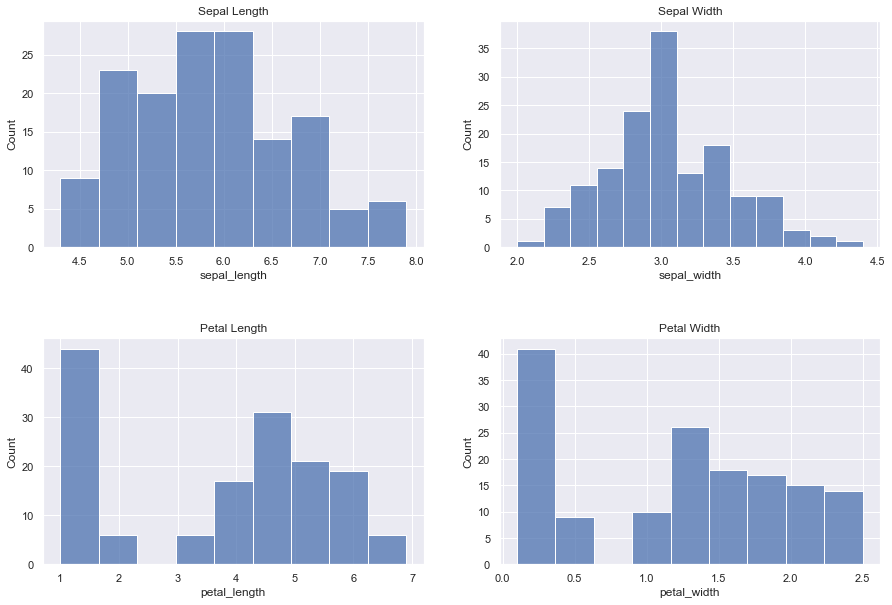

In [43]:
#(c) 
#histograms for continuous valued features:
seaborn.set()
fig, axes = pyplot.subplots(2, 2, figsize=(15,10))
pyplot.subplots_adjust(wspace=0.2, hspace=0.4)
axes[0][0].set_title("Sepal Length")
axes[0][1].set_title("Sepal Width")
axes[1][0].set_title("Petal Length")
axes[1][1].set_title("Petal Width")
seaborn.histplot(iris_df["sepal_length"], ax=axes[0][0])
seaborn.histplot(iris_df["sepal_width"], ax=axes[0][1])
seaborn.histplot(iris_df["petal_length"], ax=axes[1][0])
seaborn.histplot(iris_df["petal_width"], ax=axes[1][1])
plt.show()

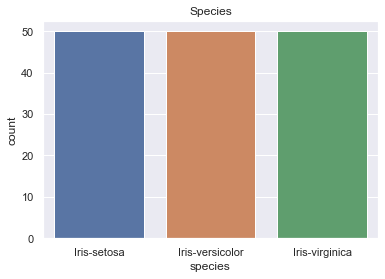

In [16]:
#barplot for discrete valued features:
seaborn.countplot(x = iris_df["species"]).set_title('Species')
plt.show()

## Part 2

(a) Load the MNIST dataset using idx2numpy

In [18]:
# Run these commands to download the datasets
# ! curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# ! curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# ! curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# ! curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [19]:
#(a) load the dataset using idx2numpy
train_images = gzip.open('train-images-idx3-ubyte.gz','r')
train_labels = gzip.open('train-labels-idx1-ubyte.gz','r')
test_images = gzip.open('t10k-images-idx3-ubyte.gz','r')
test_labels = gzip.open('t10k-labels-idx1-ubyte.gz','r')
mnist_train = idx2numpy.convert_from_file(train_images)
mnist_train_labels = idx2numpy.convert_from_file(train_labels)
mnist_test = idx2numpy.convert_from_file(test_images)
mnist_test_labels = idx2numpy.convert_from_file(test_labels)

In [20]:
def flatten(dataset, dataset_labels):
  nimages, nx, ny = dataset.shape
  lis = np.linspace(1, nx*ny, nx*ny, dtype=np.int64)
  lis = lis.tolist()
  lis = [str(x) for x in lis]
  dataset_flat = dataset.reshape((nimages, nx*ny))
  dataset_df = pd.DataFrame(dataset_flat, columns=lis)
  dataset_df['target'] = pd.Series(dataset_labels)
  return dataset_df

In [30]:
#since the dataset is big, I will create a new one with 1000 samples for each class
mnist_df = flatten(mnist_train, mnist_train_labels)
mnist_grouped = mnist_df.groupby('target')
nimages, nx, ny = mnist_train.shape
lis = np.linspace(1, nx*ny, nx*ny, dtype=np.int64)
lis = lis.tolist()
lis = [str(x) for x in lis]
lis.append('target')
mnist_short_df = pd.DataFrame(columns=lis)
for i in mnist_grouped.groups:
    #concatenate row to dataframe
    mnist_short_df = pd.concat([mnist_short_df, mnist_grouped.get_group(i).sample(1000)], ignore_index=True)

mnist_short_df.reset_index(inplace=True, drop=True)
mnist_short_df.head()

,1,2,3,4,5,6,7,8,9,10,...,776,777,778,779,780,781,782,783,784,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(b) Visualise two random images from the dataset.

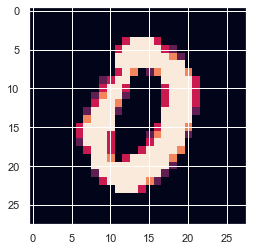

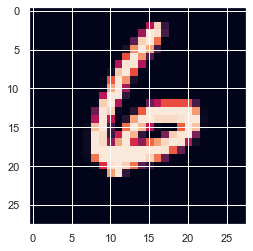

In [36]:
#(b) visualize two random images 
%matplotlib inline
rnums = random.sample(range(1, len(mnist_train)), 2)

#use these commands on jupyter notebook
plt.imshow(mnist_train[rnums[0]])
plt.show()
plt.imshow(mnist_train[rnums[1]])
plt.show()

#use these commands while working on google colab
# from google.colab.patches import cv2_imshow
# cv2_imshow(mnist_train[rnums[0]])
# cv2_imshow(mnist_train[rnums[1]])

(c) TSNE (t-distributed stochastic neighbour embedding) algorithm to reduce data dimensions to 2, and plot the resulting data as a scatter plot. Comment on the separability of the data.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


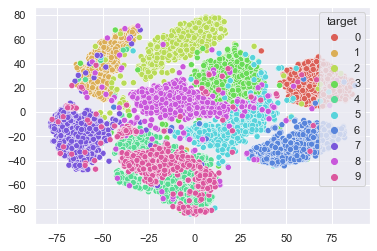

In [37]:
#(c) t-SNE on the reduced dataset of 10k training images and visualization of the resulting 2-dimensional data

tsne = TSNE(n_components = 2, random_state=4)
mnist_tsne = tsne.fit_transform(mnist_short_df.iloc[:, :-1])
seaborn.scatterplot(x = mnist_tsne[:,0], y = mnist_tsne[:,1], hue = mnist_short_df['target'], palette = seaborn.color_palette("hls", 10), legend = 'full');